# Breast Cancer Survival Time after Diagnosis  
####  Linear Model, LASSO, Cross Validation

Data source:  U.S. Department of Health and Human Services, National Institutes of Health, National Cancer Institute  
Surveillance, Epidemiology, and End Results (SEER) Program - Incidences of Breast Cancer  
https://seer.cancer.gov/    

#### Purpose  
The purpose of this analysis is the determine the factors that contribute to mortality after a breast cancer diagnosis. Such analysis will be used uncover treatment strategies and provide a baseline for effectiveness.  

In [1]:
# Standard module set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistical analysis
import statsmodels.api as sm
import scipy.stats as stats

#Supervised modeling
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Data set  
The data set has been formatted and cleaned, then read into a csv file. Many of the independent variables are categorical, dummy variables were constructed to ease analysis. The data set contains patient by patient data, covering survival times, some basic patient and neoplasm characteristics. The variables are:  
srv_time_mon - Main dependent variable. Number of months the patient survives after a diagnosis.  
p_srv - Constructed from  the depenedent variable, the probability of survival after a diagnosis.  
c_srv - Constructed from the dependent variable, the count of patients surviving to the time point.  
log_odds - An alternate dependent variable and constructed from the dependent variable, the log odds of the patient survival after a diagnosis.  
REG - Independent variable, the US region where the diagnosis occurred.  
MAR_STAT - Independent variable, marital status of the patient.  
RACE1V - Independent variable, ethnicity of the patient.   
NHIADE - Independent variable, for hispanic ethnicities, further classifications.  
SEX - Independent variable, gender of the patient.  
AGE_DX - Independent variable, age of the patient at diagnosis.  
SEQ_NUM - Independent variable, number of previous diagnoses.   
LATERAL - Independent variable, side of body of the diagnosis.  
HISTO3V - Independent variable, histologic characteristics of the diagnosis.   
BEHO3V - Independent variable, behvior characterization of the neoplasm.  
GRADE - Independent variable, a classification of the severity of the neoplasm.  
HST_STGA - Independent variable, histologic stage of the neoplasm.  
MALIGCOUNT - Independent variable, the number of malignant neoplasms at diagnosis.  
BENBORDCOUNT - Independent variable, the number of benign neoplasms at diagnosis.  
PRIMSITE_coded - Independent variable, the primary site of the diagnosis.  
           
           

In [2]:
#Dataset that has been organized and formatted
cancer_sruviv = pd.read_csv('./data/dummied.csv')

#Remove old index
cancer_sruviv = cancer_sruviv.drop('Unnamed: 0', axis=1)


In [3]:
#Split training and testing sets
train, test = train_test_split(cancer_sruviv)

#### Analysis  
The linear model to survival time in months has a relatively low coefficient of determination. Other models may show improvement.

In [4]:
#Set up response and factors
x = train.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds'], axis=1)
y = train.srv_time_mon

#Fit model
model = LassoCV(cv=20, random_state=0).fit(x, y)
print(f'Coefficient of determination: {np.round(model.score(x, y), 2)}')

Coefficient of determination: 0.24


In [5]:
#Make a list of dependent variables and coefficients. 
a = list()
for i in enumerate(np.round(model.coef_,2)):
    b = (x.columns[i[0]], i[1])
    a.append(b)
# a.insert(0,('intercept:',np.round(model.intercept_)))    

In [6]:
coefficients = pd.DataFrame(a, columns = ['variable', 'coefficient'])
coefficients.sort_values(['coefficient'], axis=0, ascending=False, 
                         inplace=True, kind='quicksort', na_position='last')
best_coefficients = coefficients[coefficients['coefficient'] > 0]

#### Residuals  
The distribution of residuals show deviation from normal and possible heteroskedasticity (against fitted values). The training set and testing set look similar.  Check for correct model specification.   

In [7]:
#Resdiual analysis
y_pred = model.predict(x)
resid = y_pred - y
resid_stand = (resid.mean() - resid) / resid.std()

ks = stats.kstest(resid_stand, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid**2) / (len(resid) - len(x.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid**2) / np.sum((y.mean() - y)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 62.48
Relative root residual error:  0.87
KS test for normal residual distribution: 0.0


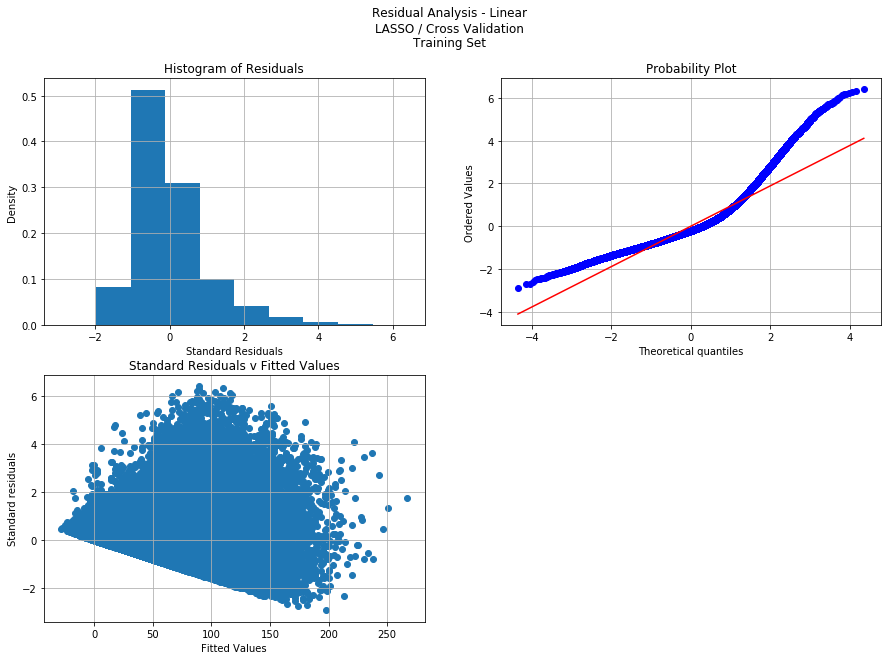

In [8]:
#Grapnical residual analysis
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis - Linear\nLASSO / Cross Validation\n'
              'Training Set')

ax1 = plt.subplot(221)
plt.hist(resid_stand, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand, plot=plt)
plt.grid()

ax= plt.subplot(223)
plt.scatter(y_pred, resid_stand)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()
# plt.savefig('./images/fig_1_resid_linear.png', transparent=True)
plt.show()





In [9]:
x_test = test.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds'], axis=1)
y_test = test.srv_time_mon
print(f'Coefficient of determination: {np.round(model.score(x_test, y_test), 2)}')

Coefficient of determination: 0.24


In [10]:
#Residual analysis of the test set

test_fit = model.predict(x_test)
test_resid = test_fit - y_test
test_resid_stand = (test_resid.mean() - test_resid) / test_resid.std()

ks_test = stats.kstest(test_resid_stand, 'norm')[1]
rsd_test = np.round(np.sqrt(np.sum(test_resid**2) / (len(test_resid) - len(x_test.columns))) ,2)
rrse_test = np.round(np.sqrt(np.sum(test_resid**2) / np.sum((y_test.mean() - y_test)**2)), 2)
print(f'Residual sd: {rsd_test}\n'
      f'Relative root residual error:  {rrse_test}\n'
      f'KS test for normal residual distribution: '
      f'{ks_test}')

Residual sd: 63.38
Relative root residual error:  0.87
KS test for normal residual distribution: 0.0


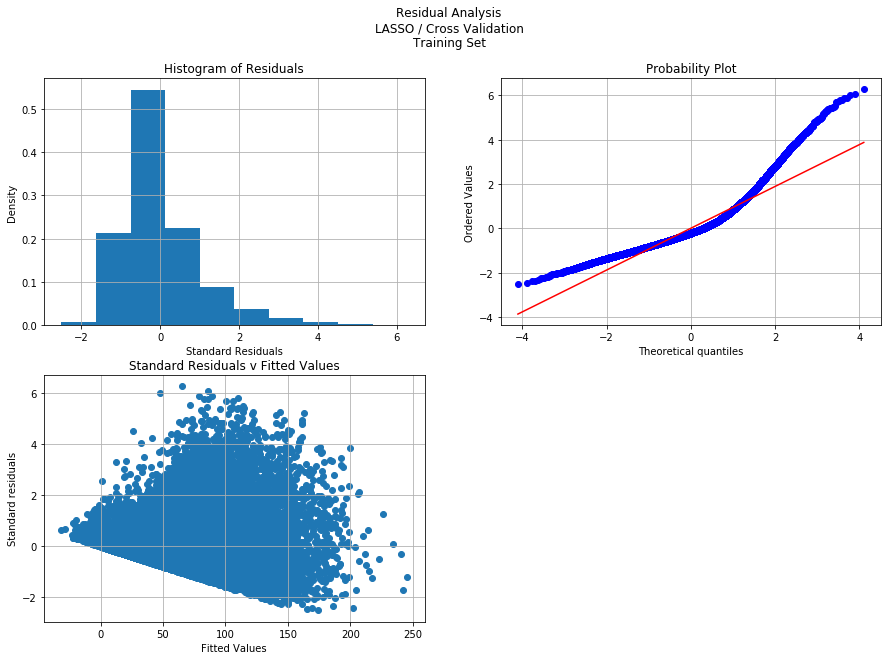

In [11]:
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis\nLASSO / Cross Validation\n'
             'Training Set')

ax1 = plt.subplot(221)
plt.hist(test_resid_stand, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(test_resid_stand, plot=plt)
plt.grid()

ax3 = plt.subplot(223)
plt.scatter(test_fit, test_resid_stand)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()

# plt.savefig('./images/fig_2_resid_linear.png', transparent=True)
plt.show()

In [12]:
# for i in enumerate(x_test.columns):
#     plt.figure(figsize=(15,(np.floor(len(x_test.columns)/2)+1)*5))
#     plt.subplot(np.floor(len(x_test.columns)/2)+1,2,i[0]+1)
#     plt.scatter(test[i[1]], test_resid_stand)
#     plt.title(f'Residuals to {i[1]}')
#     plt.ylabel('Standardized Residuals')
#     plt.xlabel(f'{i[1]} values')
#     plt.grid()
#     plt.show()

In [13]:
weights = train
weights['y_pred'] = model.predict(x)

weights['resid'] = (weights['y_pred'] - weights['srv_time_mon'])**2

resid_sum = weights.groupby('srv_time_mon')['resid'].sum()
mon_count = weights.groupby('srv_time_mon')['srv_time_mon'].count()

weights['resid_sum'] = weights['srv_time_mon'].map(resid_sum)
weights['mon_count'] = weights['srv_time_mon'].map(mon_count)
weights['weight'] = np.sqrt(weights['resid_sum'] / weights['mon_count'])
x_weights = weights.drop(['srv_time_mon', 'p_srv', 'c_srv', 'log_odds',
                           'y_pred', 'resid', 'resid_sum', 'mon_count',
                           'weight'], axis=1)
y_weights = weights['srv_time_mon']
w_weights = weights['weight']

In [14]:
wls_model = sm.WLS(y_weights,x_weights, weights=w_weights).fit()
print(f'Coefficient of determination: {np.round(wls_model.rsquared, 2)}')

Coefficient of determination: 0.34


In [15]:
y_pred_wls = wls_model.predict(x_weights)
resid_wls = y_pred_wls - y_weights
resid_stand_wls = (resid_wls.mean() - resid_wls) / resid_wls.std()

ks = stats.kstest(resid_stand_wls, 'norm')[1]
rsd = np.round(np.sqrt(np.sum(resid_wls**2) / (len(resid_wls) - len(x_weights.columns))) ,2)
rrse = np.round(np.sqrt(np.sum(resid_wls**2) / np.sum((y.mean() - y_weights)**2)), 2)
print(f'Residual sd: {rsd}\n'
      f'Relative root residual error:  {rrse}\n'
      f'KS test for normal residual distribution: '
      f'{ks}')

Residual sd: 71.84
Relative root residual error:  1.0
KS test for normal residual distribution: 1.2911112042850541e-169


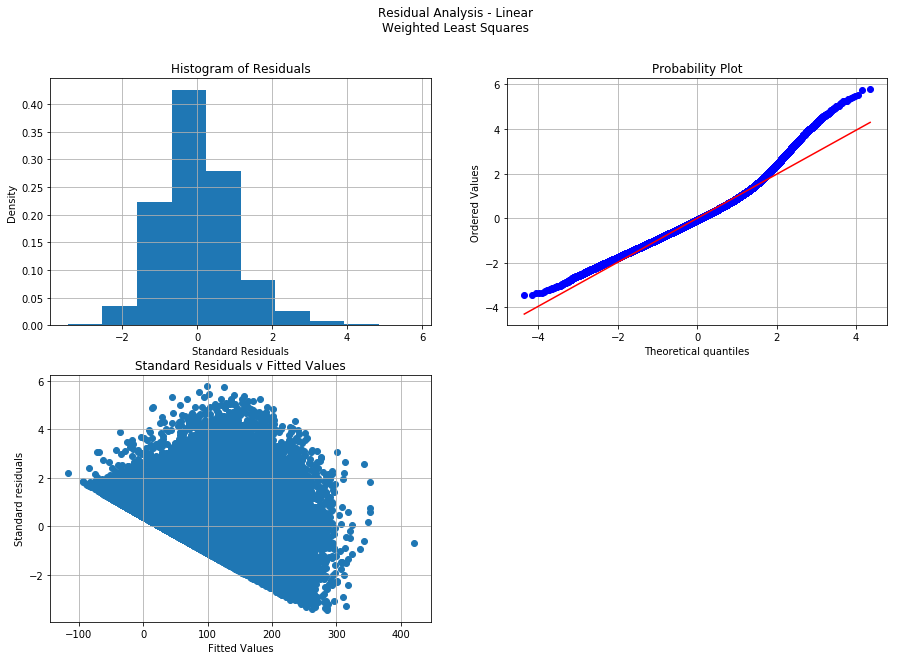

In [16]:
#Grapnical residual analysis
plt.figure(figsize=(15,10))
plt.suptitle('Residual Analysis - Linear\nWeighted Least Squares')

ax1 = plt.subplot(221)
plt.hist(resid_stand_wls, density=True)
plt.title('Histogram of Residuals')
plt.xlabel('Standard Residuals')
plt.ylabel('Density')
plt.grid()

ax2 = plt.subplot(222)
plot = stats.probplot(resid_stand_wls, plot=plt)
plt.grid()

ax= plt.subplot(223)
plt.scatter(y_pred_wls, resid_stand_wls)
plt.title('Standard Residuals v Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Standard residuals')

plt.grid()

# plt.savefig('./images/fig_3_resid_linear.png', transparent=True)
plt.show()
